# Concept: JWST Data Analysis Use Case: NIRCam multiband photometry

## Analyzing simulated NIRCam imaging from JADES
http://fenrir.as.arizona.edu/jwstmock/ (Williams et al. 2018)

### Photometry is aperture matched, but no PSF corrections are made

## Import photutils and check it is up to date (here using 0.7.1)

In [1]:
import photutils
photutils.__version__

'0.7.1'

## Load detection image

In [2]:
from astropy.io import fits
import astropy.wcs as wcs
filt = 'F200W'
infile = '../images/goods_s_crop_%s.fits' % filt
hdu = fits.open(infile)
data = hdu[0].data
imwcs = wcs.WCS(hdu[0].header, hdu)

## Measure background
https://photutils.readthedocs.io/en/latest/segmentation.html

In [3]:
from photutils import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (2. * bkg.background_rms)

## Detect sources

In [4]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

## Deblend sources

In [5]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5, filter_kernel=kernel, nlevels=32, contrast=0.001)

## Show detections (optional)

Text(0.5, 1.0, 'Segmentation Image w/ deblending')

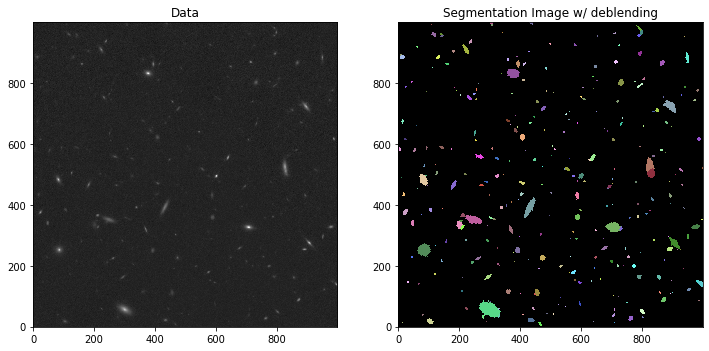

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12.5))

# Data
norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')

# Segmentation map
cmap = segm_deblend.make_cmap(random_state=12345)  # ERROR
ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image w/ deblending')

## Measure photometry (and more) in detection image
https://photutils.readthedocs.io/en/latest/segmentation.html#centroids-photometry-and-morphological-properties

In [7]:
from photutils import source_properties
from photutils.utils import calc_total_error
effective_gain = 500.  # SHOULD USE THE WEIGHT IMAGE HERE
error = calc_total_error(data, bkg.background_rms, effective_gain)
cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

## Only keep some quantities

In [8]:
# I don't know how to split sky_centroid into (ra, dec)
# Also "area" has units, so how to format?
columns = 'id xcentroid ycentroid sky_centroid area ellipticity orientation gini'.split()
tbl = cat.to_table(columns=columns)
tbl['id'].info.format = 'd'
#tbl['area'].info.format = '{:d}'
for column in columns:
    if column not in 'id area sky_centroid'.split():
        tbl[column].info.format = '.4f'

## Convert measured fluxes (data units) to magnitudes

In [9]:
# not detected: mag =  99; magerr = 1-sigma limit
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr, zp):
    nondet = flux < 0
    unobs  = fluxerr <= 0

    mag = zp - 2.5 * np.log10(flux)

    mag = np.where(nondet, 99, mag)
    mag = np.where(unobs, -99, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux)
    magupperlimit = zp - 2.5 * np.log10(fluxerr)

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0, magerr)

    return mag, magerr

## Multiband photometry using isophotal apertures defined in detection image
(Similar to running SourceExtractor in double-image mode)

In [10]:
from glob import glob
filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()
for filt in filters:
    infile = '../images/goods_s_crop_%s.fits' % filt
    print(filt, infile)
    hdu = fits.open(infile)
    data = hdu[0].data
    zp = hdu[0].header['ABMAG']
    
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    error = calc_total_error(data, bkg.background_rms, effective_gain)
    filtcat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

    filttbl = filtcat.to_table()
    flux = filttbl['source_sum']
    fluxerr = filttbl['source_sum_err']
    mag, magerr = fluxes2mags(flux, fluxerr, zp)
    tbl[filt+'_mag'] = mag
    tbl[filt+'_magerr'] = magerr

F090W ../images/goods_s_crop_F090W.fits
F115W ../images/goods_s_crop_F115W.fits
F150W ../images/goods_s_crop_F150W.fits
F200W ../images/goods_s_crop_F200W.fits
F277W ../images/goods_s_crop_F277W.fits
F335M ../images/goods_s_crop_F335M.fits
F356W ../images/goods_s_crop_F356W.fits
F410M ../images/goods_s_crop_F410M.fits
F444W ../images/goods_s_crop_F444W.fits


## Save photometry as output catalog

In [11]:
for filt in filters:
    tbl[filt+'_mag'].info.format = '.4f'
    tbl[filt+'_magerr'].info.format = '.4f'

tbl.write('JADEScrop.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

## View results (optional)

In [12]:
tbl

id,xcentroid,ycentroid,sky_centroid,area,ellipticity,orientation,gini,F090W_mag,F090W_magerr,F115W_mag,F115W_magerr,F150W_mag,F150W_magerr,F200W_mag,F200W_magerr,F277W_mag,F277W_magerr,F335M_mag,F335M_magerr,F356W_mag,F356W_magerr,F410M_mag,F410M_magerr,F444W_mag,F444W_magerr
,pix,pix,"deg,deg",pix2,,deg,,,,,,,,,,,,,,,,,,,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,466.2447,8.7978,"53.173810089768665,-27.80532082877889",101.0,0.4594,-44.4808,0.3747,28.9956,0.1123,28.4396,0.0757,28.2405,0.0618,28.1272,0.0539,28.4390,0.0624,28.5341,0.0945,28.5210,0.0614,28.5429,0.0898,28.5485,0.0613
2,104.8267,18.0731,"53.17721504245484,-27.805243269026736",276.0,0.3485,-26.4769,0.4294,26.8260,0.0389,26.8128,0.0354,26.7709,0.0313,26.6596,0.0274,26.7368,0.0283,26.7006,0.0409,26.7597,0.0271,26.9212,0.0427,27.0017,0.0298
3,15.0438,13.2191,"53.17806090163139,-27.805283640154833",8.0,0.2140,-38.1324,0.1056,32.7065,0.6114,31.6865,0.3139,31.7606,0.3023,31.4772,0.2461,32.5377,0.3463,32.0333,0.4049,32.8343,0.3789,99.0000,33.9569,33.7157,0.6817
4,710.3234,14.2603,"53.17151059358405,-27.805275439752858",25.0,0.1241,-59.3582,0.3357,30.3323,0.1895,29.9425,0.1416,29.8978,0.1266,30.0162,0.1242,30.8142,0.1697,30.8877,0.2486,30.6460,0.1525,30.6738,0.2171,30.8644,0.1642
5,434.5284,22.2140,"53.17410888331507,-27.80520900678579",267.0,0.3373,-8.1945,0.5357,27.1954,0.0467,27.0665,0.0400,26.9895,0.0348,26.6028,0.0265,26.0914,0.0213,26.0884,0.0309,26.0060,0.0193,25.8808,0.0265,25.9742,0.0186
6,289.3878,17.2818,"53.17547627312846,-27.80525000886962",17.0,0.0724,68.1487,0.1802,31.2542,0.3171,30.9595,0.2297,31.3422,0.2622,30.6705,0.1741,31.2113,0.2115,30.7790,0.2545,30.9633,0.1810,31.2486,0.2972,31.9854,0.2936
7,640.4865,17.7733,"53.172168533005596,-27.80524613059388",21.0,0.4180,-64.7295,0.2574,30.8059,0.2332,30.8718,0.2168,30.8688,0.1994,30.5297,0.1561,31.3611,0.2079,30.8632,0.2423,31.1513,0.1869,32.3948,0.4189,32.0130,0.2580
8,762.7521,28.2985,"53.17101664985919,-27.805158478041616",203.0,0.2560,38.1564,0.5441,27.0889,0.0427,27.0291,0.0385,26.9221,0.0329,26.5385,0.0252,26.5589,0.0261,26.7232,0.0409,26.7123,0.0265,26.7714,0.0395,26.7206,0.0260
